In [ ]:
RANDOM_SEED = 42

In [ ]:
path_ = "Scalograms-rest-stacked-wavdec"

In [ ]:
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
#Preparing images for model training --- image size = 256 x 256
train_batch = 64
test_batch = 64
train_set= image_dataset_from_directory(path_,
                                labels='inferred',
                                label_mode='binary',
                                batch_size=train_batch,
                                seed=RANDOM_SEED,
                                shuffle=True,
                                validation_split=0.2,
                                subset='training')
                                
val_set =  image_dataset_from_directory(path_,
                                labels='inferred',
                                label_mode='binary',
                                batch_size=test_batch,
                                seed=RANDOM_SEED,
                                shuffle=True,
                                validation_split=0.2,
                                subset='validation')

Found 1680 files belonging to 2 classes.
Using 1344 files for training.
Found 1680 files belonging to 2 classes.
Using 336 files for validation.


In [ ]:
test_ds_size = int(int(val_set.__len__())*0.5) # test-test set has 478 images and val set has 1647 images == # 9563 * 0.05
test_test_set = val_set.take(test_ds_size)
test_set = val_set.skip(test_ds_size)

In [ ]:
print(val_set.__len__(), train_set.__len__(), test_set.__len__(), test_test_set.__len__(), sep='\n')

tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(21, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)


In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
#from keras.optimizers import gradient_descent_v2 
from keras import regularizers, initializers
from livelossplot import PlotLossesKeras
from tensorflow.keras.applications.densenet import DenseNet121

In [ ]:
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(256,256,3))
output = densenet.layers[-1].output
output = Flatten()(output)
densenet = Model(densenet.input, output)
for layer in densenet.layers:
    layer.trainable = False
densenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model_1 = Sequential()

model_1.add(densenet)
model_1.add(Dense(32,activation='relu', input_dim=(256,256,3),  kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.L2(0.5)))
model_1.add(Dense(16,activation='relu', kernel_regularizer=regularizers.L2(0.5)))
model_1.add(Dense(1,activation='sigmoid'))

model_1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy','Recall','Precision','AUC'])   

In [ ]:
root_path = "Models/rest-scalograms-TL-densenet-checkpoints/"
filepath = root_path + 'rest-scalograms-TL-l2-5-densenet-model-t1.h5'

k=2
if not os.path.exists(root_path): os.makedirs(root_path)
else: 
    while(os.path.exists(filepath)): 
        filepath = filepath[:-4] + str(k) + '.h5' 
        k = k+1

callbacks = [#EarlyStopping(monitor='val_accuracy', patience=4),
            ModelCheckpoint(filepath=filepath, monitor="val_accuracy", mode='max', save_best_only=True),
            PlotLossesKeras()]

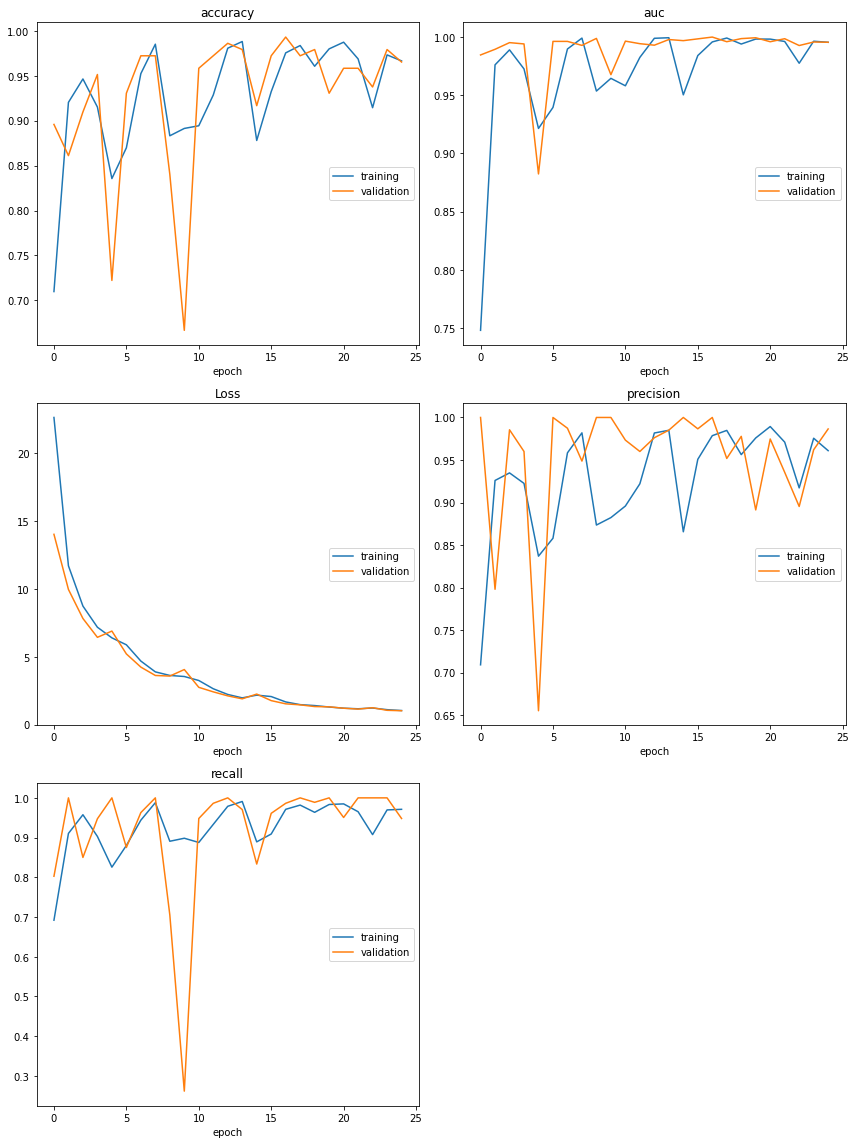

accuracy
	training         	 (min:    0.710, max:    0.988, cur:    0.967)
	validation       	 (min:    0.667, max:    0.993, cur:    0.965)
auc
	training         	 (min:    0.748, max:    0.999, cur:    0.995)
	validation       	 (min:    0.882, max:    1.000, cur:    0.996)
Loss
	training         	 (min:    1.039, max:   22.633, cur:    1.039)
	validation       	 (min:    1.024, max:   14.023, cur:    1.024)
precision
	training         	 (min:    0.709, max:    0.989, cur:    0.961)
	validation       	 (min:    0.655, max:    1.000, cur:    0.986)
recall
	training         	 (min:    0.692, max:    0.991, cur:    0.971)
	validation       	 (min:    0.262, max:    1.000, cur:    0.948)
21/21 [==============================] - 9s 438ms/step - loss: 1.0386 - accuracy: 0.9665 - recall: 0.9712 - precision: 0.9610 - auc: 0.9955 - val_loss: 1.0236 - val_accuracy: 0.9653 - val_recall: 0.9481 - val_precision: 0.9865 - val_auc: 0.9955


In [ ]:
h = model_1.fit(train_set,
                epochs=25,
                #steps_per_epoch=64,
                validation_data=test_set,
                #validation_steps=32,
                callbacks=callbacks
                )

In [ ]:
import pandas as pd

pd.DataFrame.from_dict(h.history).to_csv(filepath[:-2] + 'csv' , index=False)
#data=pd.read_csv("Models/scalogram-base-model-checkpoints/scalogram-base-model-1.csv")

In [ ]:
model_1.evaluate(test_test_set)

3/3 [==============================] - 1s 326ms/step - loss: 1.0299 - accuracy: 0.9583 - recall: 0.9333 - precision: 0.9899 - auc: 0.9966


[1.0298908948898315,
 0.9583333134651184,
 0.9333333373069763,
 0.9898989796638489,
 0.9966064691543579]